# LSTM Travel Time + Speed Prediction - Cent.2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'Cent.2')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6387,77,32,2021042800
6401,77,32,2021042800
6415,77,32,2021042800
6429,77,32,2021042800
6443,77,32,2021042800
...,...,...,...
294412,76,32,2021051509
294426,76,32,2021051509
294440,76,32,2021051509
294454,76,32,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,77.000000,32.000000
2021042801,77.000000,32.000000
2021042802,77.000000,32.000000
2021042803,77.000000,32.000000
2021042804,77.000000,32.000000
...,...,...
2021051505,76.000000,32.000000
2021051506,76.000000,32.000000
2021051507,76.000000,32.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,1.000000
2021042803,1.000000
2021042804,1.000000
...,...
2021051505,0.956034
2021051506,0.956034
2021051507,0.956034


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

# LSTM - Time

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Adagrad', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 5s 856ms/step - loss: 0.8363 - mae: 0.8200 - rmse: 0.8346 - val_loss: 0.7980 - val_mae: 0.7980 - val_rmse: 0.7980
Epoch 2/300
3/3 [==============================] - 0s 77ms/step - loss: 0.7712 - mae: 0.7554 - rmse: 0.7655 - val_loss: 0.7220 - val_mae: 0.7220 - val_rmse: 0.7220
Epoch 3/300
3/3 [==============================] - 0s 76ms/step - loss: 0.6986 - mae: 0.6819 - rmse: 0.6953 - val_loss: 0.6558 - val_mae: 0.6558 - val_rmse: 0.6558
Epoch 4/300
3/3 [==============================] - 0s 74ms/step - loss: 0.6234 - mae: 0.6067 - rmse: 0.6234 - val_loss: 0.5957 - val_mae: 0.5957 - val_rmse: 0.5957
Epoch 5/300
3/3 [==============================] - 0s 93ms/step - loss: 0.5809 - mae: 0.5646 - rmse: 0.5713 - val_loss: 0.5405 - val_mae: 0.5405 - val_rmse: 0.5405
Epoch 6/300
3/3 [==============================] - 0s 72ms/step - loss: 0.5349 - mae: 0.5215 - rmse: 0.5312 - val_loss: 0.4904 - val_mae: 0.4904 - val_rmse: 0.4904
Epoch 7/300
3/3

Epoch 51/300
3/3 [==============================] - 0s 78ms/step - loss: 0.1840 - mae: 0.1088 - rmse: 0.1686 - val_loss: 0.0525 - val_mae: 0.0525 - val_rmse: 0.0525
Epoch 52/300
3/3 [==============================] - 0s 77ms/step - loss: 0.1891 - mae: 0.1168 - rmse: 0.1690 - val_loss: 0.0515 - val_mae: 0.0515 - val_rmse: 0.0515
Epoch 53/300
3/3 [==============================] - 0s 69ms/step - loss: 0.1841 - mae: 0.1050 - rmse: 0.1659 - val_loss: 0.0505 - val_mae: 0.0505 - val_rmse: 0.0505
Epoch 54/300
3/3 [==============================] - 0s 74ms/step - loss: 0.1871 - mae: 0.1085 - rmse: 0.1714 - val_loss: 0.0493 - val_mae: 0.0493 - val_rmse: 0.0493
Epoch 55/300
3/3 [==============================] - 0s 75ms/step - loss: 0.1818 - mae: 0.1101 - rmse: 0.1660 - val_loss: 0.0481 - val_mae: 0.0481 - val_rmse: 0.0481
Epoch 56/300
3/3 [==============================] - 0s 75ms/step - loss: 0.1911 - mae: 0.1111 - rmse: 0.1719 - val_loss: 0.0471 - val_mae: 0.0471 - val_rmse: 0.0471
Epoch 57/3

3/3 [==============================] - 0s 165ms/step - loss: 0.1893 - mae: 0.0895 - rmse: 0.1670 - val_loss: 0.0258 - val_mae: 0.0258 - val_rmse: 0.0258
Epoch 101/300
3/3 [==============================] - 0s 178ms/step - loss: 0.1853 - mae: 0.0817 - rmse: 0.1625 - val_loss: 0.0256 - val_mae: 0.0256 - val_rmse: 0.0256
Epoch 102/300
3/3 [==============================] - 0s 163ms/step - loss: 0.1838 - mae: 0.0839 - rmse: 0.1622 - val_loss: 0.0253 - val_mae: 0.0253 - val_rmse: 0.0253
Epoch 103/300
3/3 [==============================] - 0s 134ms/step - loss: 0.1871 - mae: 0.0844 - rmse: 0.1665 - val_loss: 0.0250 - val_mae: 0.0250 - val_rmse: 0.0250
Epoch 104/300
3/3 [==============================] - 0s 162ms/step - loss: 0.1795 - mae: 0.0804 - rmse: 0.1583 - val_loss: 0.0248 - val_mae: 0.0248 - val_rmse: 0.0248
Epoch 105/300
3/3 [==============================] - 1s 164ms/step - loss: 0.1767 - mae: 0.0822 - rmse: 0.1545 - val_loss: 0.0247 - val_mae: 0.0247 - val_rmse: 0.0247
Epoch 106/30

3/3 [==============================] - 0s 126ms/step - loss: 0.1849 - mae: 0.0742 - rmse: 0.1649 - val_loss: 0.0174 - val_mae: 0.0174 - val_rmse: 0.0174
Epoch 150/300
3/3 [==============================] - 0s 91ms/step - loss: 0.1829 - mae: 0.0708 - rmse: 0.1625 - val_loss: 0.0172 - val_mae: 0.0172 - val_rmse: 0.0172
Epoch 151/300
3/3 [==============================] - 0s 107ms/step - loss: 0.1828 - mae: 0.0770 - rmse: 0.1594 - val_loss: 0.0172 - val_mae: 0.0172 - val_rmse: 0.0172
Epoch 152/300
3/3 [==============================] - 0s 91ms/step - loss: 0.1878 - mae: 0.0745 - rmse: 0.1637 - val_loss: 0.0170 - val_mae: 0.0170 - val_rmse: 0.0170
Epoch 153/300
3/3 [==============================] - 0s 111ms/step - loss: 0.1819 - mae: 0.0709 - rmse: 0.1581 - val_loss: 0.0170 - val_mae: 0.0170 - val_rmse: 0.0170
Epoch 154/300
3/3 [==============================] - 0s 132ms/step - loss: 0.1846 - mae: 0.0721 - rmse: 0.1614 - val_loss: 0.0169 - val_mae: 0.0169 - val_rmse: 0.0169
Epoch 155/300


3/3 [==============================] - 0s 110ms/step - loss: 0.1863 - mae: 0.0719 - rmse: 0.1636 - val_loss: 0.0131 - val_mae: 0.0131 - val_rmse: 0.0131
Epoch 199/300
3/3 [==============================] - 0s 93ms/step - loss: 0.1849 - mae: 0.0694 - rmse: 0.1624 - val_loss: 0.0130 - val_mae: 0.0130 - val_rmse: 0.0130
Epoch 200/300
3/3 [==============================] - 0s 112ms/step - loss: 0.1864 - mae: 0.0702 - rmse: 0.1621 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 201/300
3/3 [==============================] - 0s 85ms/step - loss: 0.1850 - mae: 0.0666 - rmse: 0.1616 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 202/300
3/3 [==============================] - 0s 79ms/step - loss: 0.1834 - mae: 0.0692 - rmse: 0.1625 - val_loss: 0.0127 - val_mae: 0.0127 - val_rmse: 0.0127
Epoch 203/300
3/3 [==============================] - 0s 62ms/step - loss: 0.1863 - mae: 0.0712 - rmse: 0.1627 - val_loss: 0.0127 - val_mae: 0.0127 - val_rmse: 0.0127
Epoch 204/300
3/

3/3 [==============================] - 0s 80ms/step - loss: 0.1855 - mae: 0.0687 - rmse: 0.1621 - val_loss: 0.0105 - val_mae: 0.0105 - val_rmse: 0.0105
Epoch 248/300
3/3 [==============================] - 0s 61ms/step - loss: 0.1862 - mae: 0.0663 - rmse: 0.1613 - val_loss: 0.0105 - val_mae: 0.0105 - val_rmse: 0.0105
Epoch 249/300
3/3 [==============================] - 0s 77ms/step - loss: 0.1870 - mae: 0.0699 - rmse: 0.1625 - val_loss: 0.0104 - val_mae: 0.0104 - val_rmse: 0.0104
Epoch 250/300
3/3 [==============================] - 0s 58ms/step - loss: 0.1853 - mae: 0.0670 - rmse: 0.1611 - val_loss: 0.0104 - val_mae: 0.0104 - val_rmse: 0.0104
Epoch 251/300
3/3 [==============================] - 0s 59ms/step - loss: 0.1845 - mae: 0.0662 - rmse: 0.1599 - val_loss: 0.0104 - val_mae: 0.0104 - val_rmse: 0.0104
Epoch 252/300
3/3 [==============================] - 0s 59ms/step - loss: 0.1870 - mae: 0.0698 - rmse: 0.1653 - val_loss: 0.0103 - val_mae: 0.0103 - val_rmse: 0.0103
Epoch 253/300
3/3 

3/3 [==============================] - 0s 79ms/step - loss: 0.1864 - mae: 0.0662 - rmse: 0.1618 - val_loss: 0.0086 - val_mae: 0.0086 - val_rmse: 0.0086
Epoch 297/300
3/3 [==============================] - 0s 70ms/step - loss: 0.1862 - mae: 0.0657 - rmse: 0.1619 - val_loss: 0.0086 - val_mae: 0.0086 - val_rmse: 0.0086
Epoch 298/300
3/3 [==============================] - 0s 72ms/step - loss: 0.1858 - mae: 0.0656 - rmse: 0.1620 - val_loss: 0.0085 - val_mae: 0.0085 - val_rmse: 0.0085
Epoch 299/300
3/3 [==============================] - 0s 70ms/step - loss: 0.1848 - mae: 0.0637 - rmse: 0.1607 - val_loss: 0.0085 - val_mae: 0.0085 - val_rmse: 0.0085
Epoch 300/300
3/3 [==============================] - 0s 71ms/step - loss: 0.1857 - mae: 0.0666 - rmse: 0.1603 - val_loss: 0.0085 - val_mae: 0.0085 - val_rmse: 0.0085
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


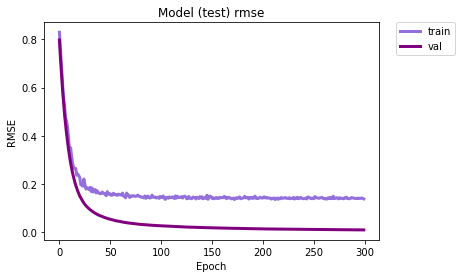

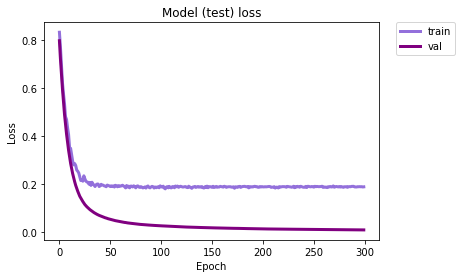

Epoch 1/300
5/5 [==============================] - 0s 71ms/step - loss: 0.1456 - mae: 0.0548 - rmse: 0.1258 - val_loss: 0.0097 - val_mae: 0.0087 - val_rmse: 0.0097
Epoch 2/300
5/5 [==============================] - 0s 59ms/step - loss: 0.1457 - mae: 0.0545 - rmse: 0.1257 - val_loss: 0.0097 - val_mae: 0.0087 - val_rmse: 0.0097
Epoch 3/300
5/5 [==============================] - 0s 60ms/step - loss: 0.1471 - mae: 0.0553 - rmse: 0.1276 - val_loss: 0.0097 - val_mae: 0.0086 - val_rmse: 0.0097
Epoch 4/300
5/5 [==============================] - 0s 61ms/step - loss: 0.1473 - mae: 0.0561 - rmse: 0.1268 - val_loss: 0.0096 - val_mae: 0.0086 - val_rmse: 0.0096
Epoch 5/300
5/5 [==============================] - 0s 62ms/step - loss: 0.1466 - mae: 0.0554 - rmse: 0.1270 - val_loss: 0.0096 - val_mae: 0.0085 - val_rmse: 0.0096
Epoch 6/300
5/5 [==============================] - 0s 59ms/step - loss: 0.1467 - mae: 0.0539 - rmse: 0.1264 - val_loss: 0.0096 - val_mae: 0.0084 - val_rmse: 0.0096
Epoch 7/300
5/5 

Epoch 51/300
5/5 [==============================] - 0s 61ms/step - loss: 0.1455 - mae: 0.0513 - rmse: 0.1256 - val_loss: 0.0088 - val_mae: 0.0072 - val_rmse: 0.0088
Epoch 52/300
5/5 [==============================] - 0s 67ms/step - loss: 0.1465 - mae: 0.0514 - rmse: 0.1276 - val_loss: 0.0088 - val_mae: 0.0072 - val_rmse: 0.0088
Epoch 53/300
5/5 [==============================] - 0s 60ms/step - loss: 0.1455 - mae: 0.0513 - rmse: 0.1248 - val_loss: 0.0088 - val_mae: 0.0072 - val_rmse: 0.0088
Epoch 54/300
5/5 [==============================] - 0s 63ms/step - loss: 0.1467 - mae: 0.0523 - rmse: 0.1259 - val_loss: 0.0088 - val_mae: 0.0071 - val_rmse: 0.0088
Epoch 55/300
5/5 [==============================] - 0s 60ms/step - loss: 0.1452 - mae: 0.0512 - rmse: 0.1245 - val_loss: 0.0088 - val_mae: 0.0071 - val_rmse: 0.0088
Epoch 56/300
5/5 [==============================] - 0s 66ms/step - loss: 0.1457 - mae: 0.0514 - rmse: 0.1250 - val_loss: 0.0088 - val_mae: 0.0071 - val_rmse: 0.0088
Epoch 57/3

Epoch 101/300
5/5 [==============================] - 0s 61ms/step - loss: 0.1453 - mae: 0.0507 - rmse: 0.1247 - val_loss: 0.0086 - val_mae: 0.0067 - val_rmse: 0.0086
Epoch 102/300
5/5 [==============================] - 0s 65ms/step - loss: 0.1452 - mae: 0.0506 - rmse: 0.1252 - val_loss: 0.0086 - val_mae: 0.0067 - val_rmse: 0.0086
Epoch 103/300
5/5 [==============================] - 0s 70ms/step - loss: 0.1454 - mae: 0.0502 - rmse: 0.1248 - val_loss: 0.0086 - val_mae: 0.0067 - val_rmse: 0.0086
Epoch 104/300
5/5 [==============================] - 0s 68ms/step - loss: 0.1449 - mae: 0.0506 - rmse: 0.1242 - val_loss: 0.0086 - val_mae: 0.0067 - val_rmse: 0.0086
Epoch 105/300
5/5 [==============================] - 0s 71ms/step - loss: 0.1453 - mae: 0.0510 - rmse: 0.1247 - val_loss: 0.0086 - val_mae: 0.0067 - val_rmse: 0.0086
Epoch 106/300
5/5 [==============================] - 0s 66ms/step - loss: 0.1469 - mae: 0.0507 - rmse: 0.1266 - val_loss: 0.0086 - val_mae: 0.0067 - val_rmse: 0.0086
Epoc

5/5 [==============================] - 0s 65ms/step - loss: 0.1447 - mae: 0.0510 - rmse: 0.1240 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 151/300
5/5 [==============================] - 0s 64ms/step - loss: 0.1461 - mae: 0.0511 - rmse: 0.1256 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 152/300
5/5 [==============================] - 0s 72ms/step - loss: 0.1461 - mae: 0.0511 - rmse: 0.1251 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 153/300
5/5 [==============================] - 0s 70ms/step - loss: 0.1458 - mae: 0.0499 - rmse: 0.1247 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 154/300
5/5 [==============================] - 0s 73ms/step - loss: 0.1448 - mae: 0.0503 - rmse: 0.1240 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 155/300
5/5 [==============================] - 0s 66ms/step - loss: 0.1461 - mae: 0.0509 - rmse: 0.1254 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 156/300
5/5 

5/5 [==============================] - 0s 74ms/step - loss: 0.1450 - mae: 0.0498 - rmse: 0.1252 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 200/300
5/5 [==============================] - 1s 171ms/step - loss: 0.1464 - mae: 0.0504 - rmse: 0.1256 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 201/300
5/5 [==============================] - 0s 67ms/step - loss: 0.1458 - mae: 0.0506 - rmse: 0.1253 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 202/300
5/5 [==============================] - 1s 118ms/step - loss: 0.1464 - mae: 0.0508 - rmse: 0.1256 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 203/300
5/5 [==============================] - 0s 88ms/step - loss: 0.1457 - mae: 0.0501 - rmse: 0.1248 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 204/300
5/5 [==============================] - 0s 69ms/step - loss: 0.1454 - mae: 0.0505 - rmse: 0.1245 - val_loss: 0.0086 - val_mae: 0.0066 - val_rmse: 0.0086
Epoch 205/300
5/

5/5 [==============================] - 0s 68ms/step - loss: 0.1455 - mae: 0.0508 - rmse: 0.1248 - val_loss: 0.0086 - val_mae: 0.0065 - val_rmse: 0.0086
Epoch 249/300
5/5 [==============================] - 0s 76ms/step - loss: 0.1463 - mae: 0.0497 - rmse: 0.1263 - val_loss: 0.0086 - val_mae: 0.0065 - val_rmse: 0.0086
Epoch 250/300
5/5 [==============================] - 0s 67ms/step - loss: 0.1463 - mae: 0.0508 - rmse: 0.1252 - val_loss: 0.0086 - val_mae: 0.0065 - val_rmse: 0.0086
Epoch 251/300
5/5 [==============================] - 0s 63ms/step - loss: 0.1457 - mae: 0.0508 - rmse: 0.1249 - val_loss: 0.0086 - val_mae: 0.0065 - val_rmse: 0.0086
Epoch 252/300
5/5 [==============================] - 0s 84ms/step - loss: 0.1463 - mae: 0.0513 - rmse: 0.1260 - val_loss: 0.0086 - val_mae: 0.0065 - val_rmse: 0.0086
Epoch 253/300
5/5 [==============================] - 0s 61ms/step - loss: 0.1459 - mae: 0.0501 - rmse: 0.1259 - val_loss: 0.0086 - val_mae: 0.0065 - val_rmse: 0.0086
Epoch 254/300
5/5 

5/5 [==============================] - 0s 87ms/step - loss: 0.1458 - mae: 0.0509 - rmse: 0.1250 - val_loss: 0.0086 - val_mae: 0.0064 - val_rmse: 0.0086
Epoch 298/300
5/5 [==============================] - 0s 85ms/step - loss: 0.1461 - mae: 0.0506 - rmse: 0.1263 - val_loss: 0.0086 - val_mae: 0.0064 - val_rmse: 0.0086
Epoch 299/300
5/5 [==============================] - 0s 87ms/step - loss: 0.1462 - mae: 0.0499 - rmse: 0.1258 - val_loss: 0.0086 - val_mae: 0.0064 - val_rmse: 0.0086
Epoch 300/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1458 - mae: 0.0506 - rmse: 0.1254 - val_loss: 0.0086 - val_mae: 0.0064 - val_rmse: 0.0086
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


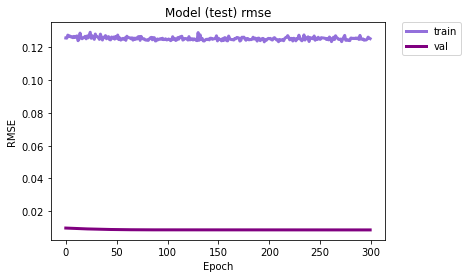

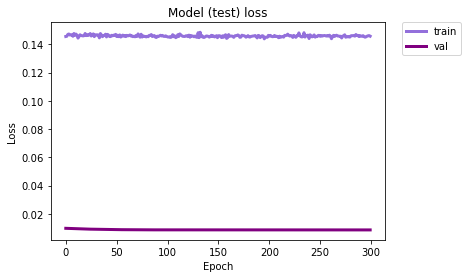

Epoch 1/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1058 - mae: 0.0376 - rmse: 0.1040 - val_loss: 0.2183 - val_mae: 0.0630 - val_rmse: 0.1208
Epoch 2/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1053 - mae: 0.0376 - rmse: 0.1034 - val_loss: 0.2183 - val_mae: 0.0630 - val_rmse: 0.1208
Epoch 3/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1069 - mae: 0.0391 - rmse: 0.1049 - val_loss: 0.2183 - val_mae: 0.0630 - val_rmse: 0.1208
Epoch 4/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1062 - mae: 0.0381 - rmse: 0.1043 - val_loss: 0.2183 - val_mae: 0.0630 - val_rmse: 0.1208
Epoch 5/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1060 - mae: 0.0383 - rmse: 0.1041 - val_loss: 0.2183 - val_mae: 0.0630 - val_rmse: 0.1208
Epoch 6/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1048 - mae: 0.0381 - rmse: 0.1030 - val_loss: 0.2183 - val_mae: 0.0630 - val_rmse: 0.1208
Epoch 7/300
7/7 

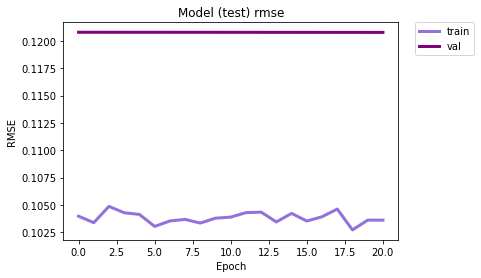

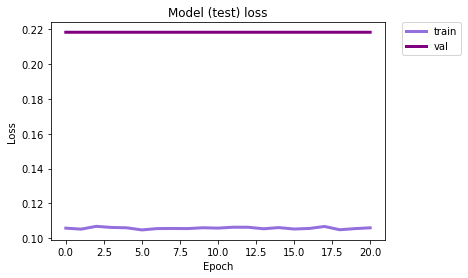

Epoch 1/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1138 - mae: 0.0375 - rmse: 0.1059 - val_loss: 0.0239 - val_mae: 0.0136 - val_rmse: 0.0355
Epoch 2/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1137 - mae: 0.0381 - rmse: 0.1058 - val_loss: 0.0239 - val_mae: 0.0136 - val_rmse: 0.0355
Epoch 3/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1134 - mae: 0.0376 - rmse: 0.1054 - val_loss: 0.0239 - val_mae: 0.0136 - val_rmse: 0.0355
Epoch 4/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1141 - mae: 0.0381 - rmse: 0.1061 - val_loss: 0.0239 - val_mae: 0.0136 - val_rmse: 0.0355
Epoch 5/300
9/9 [==============================] - 1s 87ms/step - loss: 0.1136 - mae: 0.0385 - rmse: 0.1056 - val_loss: 0.0239 - val_mae: 0.0136 - val_rmse: 0.0355
Epoch 6/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1140 - mae: 0.0382 - rmse: 0.1060 - val_loss: 0.0239 - val_mae: 0.0136 - val_rmse: 0.0355
Epoch 7/300
9/9 

9/9 [==============================] - 1s 79ms/step - loss: 0.1136 - mae: 0.0380 - rmse: 0.1058 - val_loss: 0.0238 - val_mae: 0.0135 - val_rmse: 0.0354
Epoch 51/300
9/9 [==============================] - 1s 76ms/step - loss: 0.1138 - mae: 0.0376 - rmse: 0.1060 - val_loss: 0.0238 - val_mae: 0.0135 - val_rmse: 0.0354
Epoch 52/300
9/9 [==============================] - 1s 76ms/step - loss: 0.1135 - mae: 0.0378 - rmse: 0.1062 - val_loss: 0.0238 - val_mae: 0.0135 - val_rmse: 0.0354
Epoch 53/300
9/9 [==============================] - 1s 76ms/step - loss: 0.1137 - mae: 0.0380 - rmse: 0.1060 - val_loss: 0.0238 - val_mae: 0.0135 - val_rmse: 0.0354
Epoch 54/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1139 - mae: 0.0379 - rmse: 0.1059 - val_loss: 0.0238 - val_mae: 0.0135 - val_rmse: 0.0354
Epoch 55/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1136 - mae: 0.0383 - rmse: 0.1057 - val_loss: 0.0238 - val_mae: 0.0135 - val_rmse: 0.0354
Epoch 56/300
9/9 [=====

Epoch 100/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1138 - mae: 0.0378 - rmse: 0.1059 - val_loss: 0.0238 - val_mae: 0.0134 - val_rmse: 0.0354
Epoch 101/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1134 - mae: 0.0371 - rmse: 0.1055 - val_loss: 0.0238 - val_mae: 0.0134 - val_rmse: 0.0354
Epoch 102/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1136 - mae: 0.0372 - rmse: 0.1055 - val_loss: 0.0238 - val_mae: 0.0134 - val_rmse: 0.0354
Epoch 103/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1136 - mae: 0.0377 - rmse: 0.1059 - val_loss: 0.0238 - val_mae: 0.0134 - val_rmse: 0.0354
Epoch 104/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1138 - mae: 0.0377 - rmse: 0.1063 - val_loss: 0.0238 - val_mae: 0.0134 - val_rmse: 0.0354
Epoch 105/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1132 - mae: 0.0371 - rmse: 0.1051 - val_loss: 0.0238 - val_mae: 0.0134 - val_rmse: 0.0354
Epoc

9/9 [==============================] - 1s 79ms/step - loss: 0.1133 - mae: 0.0372 - rmse: 0.1053 - val_loss: 0.0237 - val_mae: 0.0133 - val_rmse: 0.0354
Epoch 150/300
9/9 [==============================] - 1s 78ms/step - loss: 0.1135 - mae: 0.0370 - rmse: 0.1055 - val_loss: 0.0237 - val_mae: 0.0133 - val_rmse: 0.0354
Epoch 151/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1132 - mae: 0.0372 - rmse: 0.1050 - val_loss: 0.0237 - val_mae: 0.0133 - val_rmse: 0.0354
Epoch 152/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1131 - mae: 0.0371 - rmse: 0.1051 - val_loss: 0.0237 - val_mae: 0.0133 - val_rmse: 0.0354
Epoch 153/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1143 - mae: 0.0377 - rmse: 0.1063 - val_loss: 0.0237 - val_mae: 0.0133 - val_rmse: 0.0354
Epoch 154/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1137 - mae: 0.0375 - rmse: 0.1061 - val_loss: 0.0237 - val_mae: 0.0133 - val_rmse: 0.0354
Epoch 155/300
9/9 

9/9 [==============================] - 1s 85ms/step - loss: 0.1136 - mae: 0.0378 - rmse: 0.1057 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 199/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1143 - mae: 0.0378 - rmse: 0.1063 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 200/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1129 - mae: 0.0374 - rmse: 0.1056 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 201/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1138 - mae: 0.0379 - rmse: 0.1059 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 202/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1138 - mae: 0.0377 - rmse: 0.1059 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 203/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1135 - mae: 0.0371 - rmse: 0.1056 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 204/300
9/9 

9/9 [==============================] - 1s 84ms/step - loss: 0.1132 - mae: 0.0368 - rmse: 0.1053 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 248/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1137 - mae: 0.0370 - rmse: 0.1059 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 249/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1139 - mae: 0.0375 - rmse: 0.1061 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 250/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1137 - mae: 0.0372 - rmse: 0.1058 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 251/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1138 - mae: 0.0378 - rmse: 0.1058 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 252/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1132 - mae: 0.0371 - rmse: 0.1053 - val_loss: 0.0236 - val_mae: 0.0132 - val_rmse: 0.0353
Epoch 253/300
9/9 

9/9 [==============================] - 1s 80ms/step - loss: 0.1130 - mae: 0.0368 - rmse: 0.1048 - val_loss: 0.0235 - val_mae: 0.0131 - val_rmse: 0.0353
Epoch 297/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1138 - mae: 0.0375 - rmse: 0.1057 - val_loss: 0.0235 - val_mae: 0.0131 - val_rmse: 0.0353
Epoch 298/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1136 - mae: 0.0370 - rmse: 0.1055 - val_loss: 0.0235 - val_mae: 0.0131 - val_rmse: 0.0353
Epoch 299/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1133 - mae: 0.0366 - rmse: 0.1054 - val_loss: 0.0235 - val_mae: 0.0131 - val_rmse: 0.0353
Epoch 300/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1135 - mae: 0.0369 - rmse: 0.1056 - val_loss: 0.0235 - val_mae: 0.0131 - val_rmse: 0.0353
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


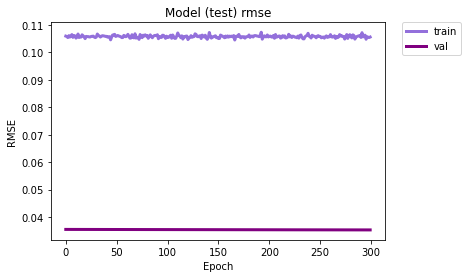

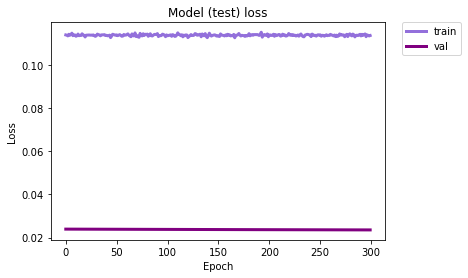

Epoch 1/300
11/11 [==============================] - 1s 81ms/step - loss: 0.0972 - mae: 0.0322 - rmse: 0.0930 - val_loss: 0.1929 - val_mae: 0.0622 - val_rmse: 0.1977
Epoch 2/300
11/11 [==============================] - 1s 79ms/step - loss: 0.0965 - mae: 0.0327 - rmse: 0.0923 - val_loss: 0.1929 - val_mae: 0.0622 - val_rmse: 0.1977
Epoch 3/300
11/11 [==============================] - 1s 87ms/step - loss: 0.0970 - mae: 0.0320 - rmse: 0.0927 - val_loss: 0.1929 - val_mae: 0.0622 - val_rmse: 0.1977
Epoch 4/300
11/11 [==============================] - 1s 88ms/step - loss: 0.0969 - mae: 0.0326 - rmse: 0.0926 - val_loss: 0.1929 - val_mae: 0.0622 - val_rmse: 0.1977
Epoch 5/300
11/11 [==============================] - 1s 82ms/step - loss: 0.0968 - mae: 0.0326 - rmse: 0.0926 - val_loss: 0.1929 - val_mae: 0.0622 - val_rmse: 0.1977
Epoch 6/300
11/11 [==============================] - 1s 76ms/step - loss: 0.0972 - mae: 0.0332 - rmse: 0.0930 - val_loss: 0.1929 - val_mae: 0.0622 - val_rmse: 0.1977
Epoc

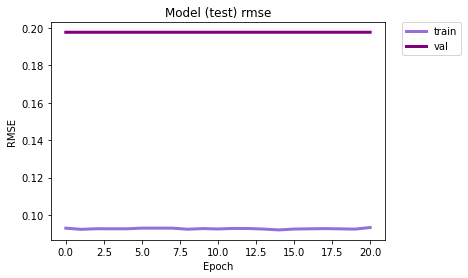

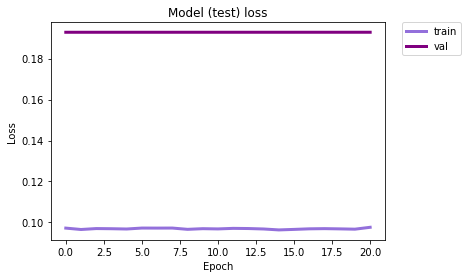

In [16]:
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.9962173
Transformed yhat 31.59584
yhat -0.9962471
Transformed yhat 31.595163
yhat -0.9962512
Transformed yhat 31.595072
yhat -0.99625504
Transformed yhat 31.594984
yhat -0.99625844
Transformed yhat 31.594906
yhat -0.9962615
Transformed yhat 31.594837
yhat -0.9962665
Transformed yhat 31.594725
yhat -0.99627644
Transformed yhat 31.594496
yhat -0.99630195
Transformed yhat 31.593916
yhat -0.9963024
Transformed yhat 31.593904
yhat -0.99630105
Transformed yhat 31.593937
yhat -0.9963
Transformed yhat 31.593962
Real data: [35.41937649 31.50980392 31.50980392 31.50980392 31.50980392 31.92395356
 32.82584404 35.80039416 31.80799166 31.50980392 31.50980392 31.50980392
 31.50980392 31.50980392 31.50980392 31.50980392 31.50980392 31.50980392
 31.50980392 31.50980392 31.50980392 31.50980392 31.91598914 31.50980392]
Forecasting values: [31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6, 31.6]


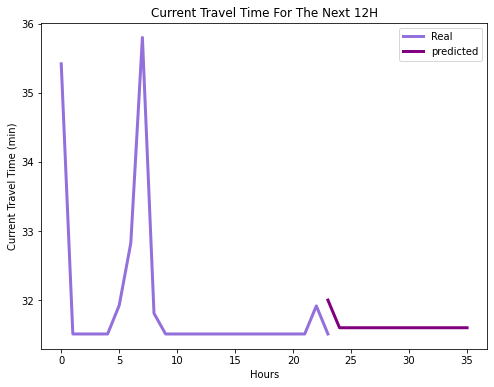

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.2',forecasts[i],hour[i]
        writer.writerow(d) 

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 10s 1s/step - loss: 0.9973 - mae: 0.9757 - rmse: 1.0024 - val_loss: 0.9728 - val_mae: 0.9728 - val_rmse: 0.9728
Epoch 2/300
3/3 [==============================] - 0s 117ms/step - loss: 0.9099 - mae: 0.8890 - rmse: 0.9106 - val_loss: 0.8872 - val_mae: 0.8872 - val_rmse: 0.8872
Epoch 3/300
3/3 [==============================] - 0s 149ms/step - loss: 0.8386 - mae: 0.8164 - rmse: 0.8431 - val_loss: 0.8119 - val_mae: 0.8119 - val_rmse: 0.8119
Epoch 4/300
3/3 [==============================] - 0s 116ms/step - loss: 0.7515 - mae: 0.7334 - rmse: 0.7484 - val_loss: 0.7448 - val_mae: 0.7448 - val_rmse: 0.7448
Epoch 5/300
3/3 [==============================] - 0s 160ms/step - loss: 0.7077 - mae: 0.6890 - rmse: 0.7088 - val_loss: 0.6848 - val_mae: 0.6848 - val_rmse: 0.6848
Epoch 6/300
3/3 [==============================] - 0s 92ms/step - loss: 0.6604 - mae: 0.6404 - rmse: 0.6531 - val_loss: 0.6278 - val_mae: 0.6278 - val_rmse: 0.6278
Epoch 7/300
3

3/3 [==============================] - 0s 121ms/step - loss: 0.2405 - mae: 0.1358 - rmse: 0.2154 - val_loss: 0.0721 - val_mae: 0.0721 - val_rmse: 0.0721
Epoch 51/300
3/3 [==============================] - 0s 88ms/step - loss: 0.2503 - mae: 0.1444 - rmse: 0.2255 - val_loss: 0.0703 - val_mae: 0.0703 - val_rmse: 0.0703
Epoch 52/300
3/3 [==============================] - 0s 100ms/step - loss: 0.2448 - mae: 0.1427 - rmse: 0.2200 - val_loss: 0.0688 - val_mae: 0.0688 - val_rmse: 0.0688
Epoch 53/300
3/3 [==============================] - 0s 107ms/step - loss: 0.2472 - mae: 0.1405 - rmse: 0.2252 - val_loss: 0.0669 - val_mae: 0.0669 - val_rmse: 0.0669
Epoch 54/300
3/3 [==============================] - 0s 102ms/step - loss: 0.2441 - mae: 0.1373 - rmse: 0.2192 - val_loss: 0.0656 - val_mae: 0.0656 - val_rmse: 0.0656
Epoch 55/300
3/3 [==============================] - 0s 104ms/step - loss: 0.2400 - mae: 0.1334 - rmse: 0.2179 - val_loss: 0.0640 - val_mae: 0.0640 - val_rmse: 0.0640
Epoch 56/300
3/3 [

3/3 [==============================] - 1s 224ms/step - loss: 0.2397 - mae: 0.1049 - rmse: 0.2131 - val_loss: 0.0348 - val_mae: 0.0348 - val_rmse: 0.0348
Epoch 100/300
3/3 [==============================] - 0s 162ms/step - loss: 0.2432 - mae: 0.1061 - rmse: 0.2137 - val_loss: 0.0344 - val_mae: 0.0344 - val_rmse: 0.0344
Epoch 101/300
3/3 [==============================] - 0s 134ms/step - loss: 0.2459 - mae: 0.1067 - rmse: 0.2195 - val_loss: 0.0340 - val_mae: 0.0340 - val_rmse: 0.0340
Epoch 102/300
3/3 [==============================] - 0s 180ms/step - loss: 0.2393 - mae: 0.1056 - rmse: 0.2114 - val_loss: 0.0336 - val_mae: 0.0336 - val_rmse: 0.0336
Epoch 103/300
3/3 [==============================] - 0s 127ms/step - loss: 0.2430 - mae: 0.1069 - rmse: 0.2134 - val_loss: 0.0333 - val_mae: 0.0333 - val_rmse: 0.0333
Epoch 104/300
3/3 [==============================] - 0s 151ms/step - loss: 0.2378 - mae: 0.1054 - rmse: 0.2074 - val_loss: 0.0331 - val_mae: 0.0331 - val_rmse: 0.0331
Epoch 105/30

3/3 [==============================] - 0s 118ms/step - loss: 0.2479 - mae: 0.0965 - rmse: 0.2161 - val_loss: 0.0224 - val_mae: 0.0224 - val_rmse: 0.0224
Epoch 149/300
3/3 [==============================] - 0s 92ms/step - loss: 0.2446 - mae: 0.1000 - rmse: 0.2146 - val_loss: 0.0222 - val_mae: 0.0222 - val_rmse: 0.0222
Epoch 150/300
3/3 [==============================] - 0s 87ms/step - loss: 0.2430 - mae: 0.0932 - rmse: 0.2126 - val_loss: 0.0220 - val_mae: 0.0220 - val_rmse: 0.0220
Epoch 151/300
3/3 [==============================] - 0s 106ms/step - loss: 0.2461 - mae: 0.1001 - rmse: 0.2162 - val_loss: 0.0218 - val_mae: 0.0218 - val_rmse: 0.0218
Epoch 152/300
3/3 [==============================] - 0s 100ms/step - loss: 0.2436 - mae: 0.0975 - rmse: 0.2122 - val_loss: 0.0217 - val_mae: 0.0217 - val_rmse: 0.0217
Epoch 153/300
3/3 [==============================] - 0s 82ms/step - loss: 0.2455 - mae: 0.1025 - rmse: 0.2143 - val_loss: 0.0215 - val_mae: 0.0215 - val_rmse: 0.0215
Epoch 154/300
3

3/3 [==============================] - 0s 91ms/step - loss: 0.2456 - mae: 0.0963 - rmse: 0.2124 - val_loss: 0.0163 - val_mae: 0.0163 - val_rmse: 0.0163
Epoch 198/300
3/3 [==============================] - 0s 143ms/step - loss: 0.2454 - mae: 0.0946 - rmse: 0.2139 - val_loss: 0.0162 - val_mae: 0.0162 - val_rmse: 0.0162
Epoch 199/300
3/3 [==============================] - 0s 116ms/step - loss: 0.2441 - mae: 0.0938 - rmse: 0.2132 - val_loss: 0.0161 - val_mae: 0.0161 - val_rmse: 0.0161
Epoch 200/300
3/3 [==============================] - 0s 108ms/step - loss: 0.2456 - mae: 0.0923 - rmse: 0.2129 - val_loss: 0.0160 - val_mae: 0.0160 - val_rmse: 0.0160
Epoch 201/300
3/3 [==============================] - 0s 110ms/step - loss: 0.2469 - mae: 0.0975 - rmse: 0.2149 - val_loss: 0.0159 - val_mae: 0.0159 - val_rmse: 0.0159
Epoch 202/300
3/3 [==============================] - 0s 99ms/step - loss: 0.2439 - mae: 0.0892 - rmse: 0.2120 - val_loss: 0.0158 - val_mae: 0.0158 - val_rmse: 0.0158
Epoch 203/300


3/3 [==============================] - 0s 97ms/step - loss: 0.2464 - mae: 0.0930 - rmse: 0.2138 - val_loss: 0.0130 - val_mae: 0.0130 - val_rmse: 0.0130
Epoch 247/300
3/3 [==============================] - 0s 97ms/step - loss: 0.2465 - mae: 0.0926 - rmse: 0.2129 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 248/300
3/3 [==============================] - 0s 91ms/step - loss: 0.2466 - mae: 0.0911 - rmse: 0.2135 - val_loss: 0.0129 - val_mae: 0.0129 - val_rmse: 0.0129
Epoch 249/300
3/3 [==============================] - 0s 97ms/step - loss: 0.2456 - mae: 0.0874 - rmse: 0.2128 - val_loss: 0.0128 - val_mae: 0.0128 - val_rmse: 0.0128
Epoch 250/300
3/3 [==============================] - 0s 89ms/step - loss: 0.2481 - mae: 0.0912 - rmse: 0.2144 - val_loss: 0.0128 - val_mae: 0.0128 - val_rmse: 0.0128
Epoch 251/300
3/3 [==============================] - 0s 90ms/step - loss: 0.2478 - mae: 0.0912 - rmse: 0.2170 - val_loss: 0.0126 - val_mae: 0.0126 - val_rmse: 0.0126
Epoch 252/300
3/3 

3/3 [==============================] - 0s 101ms/step - loss: 0.2461 - mae: 0.0896 - rmse: 0.2123 - val_loss: 0.0106 - val_mae: 0.0106 - val_rmse: 0.0106
Epoch 296/300
3/3 [==============================] - 0s 99ms/step - loss: 0.2460 - mae: 0.0876 - rmse: 0.2119 - val_loss: 0.0106 - val_mae: 0.0106 - val_rmse: 0.0106
Epoch 297/300
3/3 [==============================] - 0s 92ms/step - loss: 0.2462 - mae: 0.0867 - rmse: 0.2126 - val_loss: 0.0105 - val_mae: 0.0105 - val_rmse: 0.0105
Epoch 298/300
3/3 [==============================] - 0s 114ms/step - loss: 0.2442 - mae: 0.0881 - rmse: 0.2113 - val_loss: 0.0105 - val_mae: 0.0105 - val_rmse: 0.0105
Epoch 299/300
3/3 [==============================] - 0s 159ms/step - loss: 0.2469 - mae: 0.0899 - rmse: 0.2133 - val_loss: 0.0105 - val_mae: 0.0105 - val_rmse: 0.0105
Epoch 300/300
3/3 [==============================] - 0s 115ms/step - loss: 0.2455 - mae: 0.0894 - rmse: 0.2128 - val_loss: 0.0104 - val_mae: 0.0104 - val_rmse: 0.0104
dict_keys(['lo

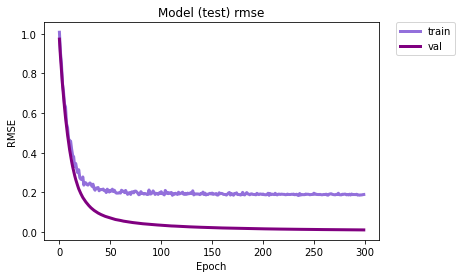

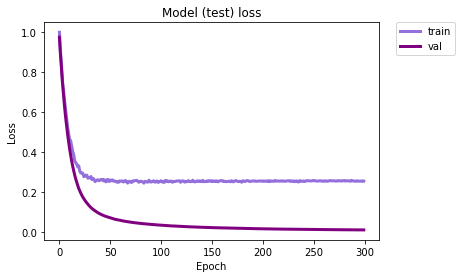

Epoch 1/300
5/5 [==============================] - 1s 210ms/step - loss: 0.2184 - mae: 0.0837 - rmse: 0.1903 - val_loss: 0.0358 - val_mae: 0.0319 - val_rmse: 0.0358
Epoch 2/300
5/5 [==============================] - 1s 134ms/step - loss: 0.2174 - mae: 0.0841 - rmse: 0.1888 - val_loss: 0.0357 - val_mae: 0.0319 - val_rmse: 0.0357
Epoch 3/300
5/5 [==============================] - 1s 188ms/step - loss: 0.2160 - mae: 0.0842 - rmse: 0.1876 - val_loss: 0.0357 - val_mae: 0.0319 - val_rmse: 0.0357
Epoch 4/300
5/5 [==============================] - 1s 215ms/step - loss: 0.2182 - mae: 0.0841 - rmse: 0.1899 - val_loss: 0.0357 - val_mae: 0.0318 - val_rmse: 0.0357
Epoch 5/300
5/5 [==============================] - 1s 146ms/step - loss: 0.2179 - mae: 0.0841 - rmse: 0.1891 - val_loss: 0.0356 - val_mae: 0.0318 - val_rmse: 0.0356
Epoch 6/300
5/5 [==============================] - 1s 126ms/step - loss: 0.2176 - mae: 0.0835 - rmse: 0.1890 - val_loss: 0.0356 - val_mae: 0.0318 - val_rmse: 0.0356
Epoch 7/30

Epoch 51/300
5/5 [==============================] - 0s 77ms/step - loss: 0.2168 - mae: 0.0851 - rmse: 0.1885 - val_loss: 0.0336 - val_mae: 0.0299 - val_rmse: 0.0336
Epoch 52/300
5/5 [==============================] - 0s 82ms/step - loss: 0.2204 - mae: 0.0872 - rmse: 0.1922 - val_loss: 0.0336 - val_mae: 0.0299 - val_rmse: 0.0336
Epoch 53/300
5/5 [==============================] - 0s 90ms/step - loss: 0.2168 - mae: 0.0848 - rmse: 0.1894 - val_loss: 0.0337 - val_mae: 0.0299 - val_rmse: 0.0337
Epoch 54/300
5/5 [==============================] - 0s 80ms/step - loss: 0.2158 - mae: 0.0831 - rmse: 0.1875 - val_loss: 0.0336 - val_mae: 0.0299 - val_rmse: 0.0336
Epoch 55/300
5/5 [==============================] - 0s 84ms/step - loss: 0.2176 - mae: 0.0858 - rmse: 0.1890 - val_loss: 0.0335 - val_mae: 0.0298 - val_rmse: 0.0335
Epoch 56/300
5/5 [==============================] - 0s 83ms/step - loss: 0.2199 - mae: 0.0867 - rmse: 0.1910 - val_loss: 0.0335 - val_mae: 0.0298 - val_rmse: 0.0335
Epoch 57/3

5/5 [==============================] - 0s 99ms/step - loss: 0.2178 - mae: 0.0871 - rmse: 0.1888 - val_loss: 0.0318 - val_mae: 0.0281 - val_rmse: 0.0318
Epoch 101/300
5/5 [==============================] - 0s 81ms/step - loss: 0.2185 - mae: 0.0864 - rmse: 0.1897 - val_loss: 0.0318 - val_mae: 0.0281 - val_rmse: 0.0318
Epoch 102/300
5/5 [==============================] - 0s 87ms/step - loss: 0.2164 - mae: 0.0872 - rmse: 0.1871 - val_loss: 0.0318 - val_mae: 0.0281 - val_rmse: 0.0318
Epoch 103/300
5/5 [==============================] - 0s 79ms/step - loss: 0.2166 - mae: 0.0843 - rmse: 0.1880 - val_loss: 0.0317 - val_mae: 0.0280 - val_rmse: 0.0317
Epoch 104/300
5/5 [==============================] - 0s 93ms/step - loss: 0.2216 - mae: 0.0905 - rmse: 0.1922 - val_loss: 0.0318 - val_mae: 0.0281 - val_rmse: 0.0318
Epoch 105/300
5/5 [==============================] - 0s 95ms/step - loss: 0.2179 - mae: 0.0863 - rmse: 0.1896 - val_loss: 0.0319 - val_mae: 0.0282 - val_rmse: 0.0319
Epoch 106/300
5/5 

5/5 [==============================] - 0s 93ms/step - loss: 0.2172 - mae: 0.0870 - rmse: 0.1880 - val_loss: 0.0306 - val_mae: 0.0269 - val_rmse: 0.0306
Epoch 150/300
5/5 [==============================] - 0s 85ms/step - loss: 0.2170 - mae: 0.0876 - rmse: 0.1877 - val_loss: 0.0306 - val_mae: 0.0269 - val_rmse: 0.0306
Epoch 151/300
5/5 [==============================] - 0s 83ms/step - loss: 0.2171 - mae: 0.0872 - rmse: 0.1880 - val_loss: 0.0305 - val_mae: 0.0268 - val_rmse: 0.0305
Epoch 152/300
5/5 [==============================] - 0s 88ms/step - loss: 0.2179 - mae: 0.0876 - rmse: 0.1890 - val_loss: 0.0305 - val_mae: 0.0268 - val_rmse: 0.0305
Epoch 153/300
5/5 [==============================] - 0s 73ms/step - loss: 0.2175 - mae: 0.0874 - rmse: 0.1887 - val_loss: 0.0305 - val_mae: 0.0268 - val_rmse: 0.0305
Epoch 154/300
5/5 [==============================] - 0s 87ms/step - loss: 0.2171 - mae: 0.0878 - rmse: 0.1874 - val_loss: 0.0304 - val_mae: 0.0267 - val_rmse: 0.0304
Epoch 155/300
5/5 

5/5 [==============================] - 0s 95ms/step - loss: 0.2145 - mae: 0.0871 - rmse: 0.1857 - val_loss: 0.0285 - val_mae: 0.0248 - val_rmse: 0.0285
Epoch 199/300
5/5 [==============================] - 0s 87ms/step - loss: 0.2157 - mae: 0.0843 - rmse: 0.1854 - val_loss: 0.0284 - val_mae: 0.0247 - val_rmse: 0.0284
Epoch 200/300
5/5 [==============================] - 0s 83ms/step - loss: 0.2183 - mae: 0.0904 - rmse: 0.1894 - val_loss: 0.0284 - val_mae: 0.0248 - val_rmse: 0.0284
Epoch 201/300
5/5 [==============================] - 0s 87ms/step - loss: 0.2157 - mae: 0.0883 - rmse: 0.1863 - val_loss: 0.0283 - val_mae: 0.0247 - val_rmse: 0.0283
Epoch 202/300
5/5 [==============================] - 0s 102ms/step - loss: 0.2172 - mae: 0.0893 - rmse: 0.1876 - val_loss: 0.0283 - val_mae: 0.0246 - val_rmse: 0.0283
Epoch 203/300
5/5 [==============================] - 0s 85ms/step - loss: 0.2180 - mae: 0.0905 - rmse: 0.1890 - val_loss: 0.0282 - val_mae: 0.0246 - val_rmse: 0.0282
Epoch 204/300
5/5

5/5 [==============================] - 0s 79ms/step - loss: 0.2210 - mae: 0.0915 - rmse: 0.1915 - val_loss: 0.0276 - val_mae: 0.0240 - val_rmse: 0.0276
Epoch 248/300
5/5 [==============================] - 0s 81ms/step - loss: 0.2151 - mae: 0.0882 - rmse: 0.1860 - val_loss: 0.0276 - val_mae: 0.0240 - val_rmse: 0.0276
Epoch 249/300
5/5 [==============================] - 0s 84ms/step - loss: 0.2177 - mae: 0.0908 - rmse: 0.1885 - val_loss: 0.0276 - val_mae: 0.0240 - val_rmse: 0.0276
Epoch 250/300
5/5 [==============================] - 0s 77ms/step - loss: 0.2127 - mae: 0.0882 - rmse: 0.1829 - val_loss: 0.0274 - val_mae: 0.0238 - val_rmse: 0.0274
Epoch 251/300
5/5 [==============================] - 0s 87ms/step - loss: 0.2165 - mae: 0.0877 - rmse: 0.1869 - val_loss: 0.0274 - val_mae: 0.0238 - val_rmse: 0.0274
Epoch 252/300
5/5 [==============================] - 0s 80ms/step - loss: 0.2191 - mae: 0.0904 - rmse: 0.1888 - val_loss: 0.0273 - val_mae: 0.0237 - val_rmse: 0.0273
Epoch 253/300
5/5 

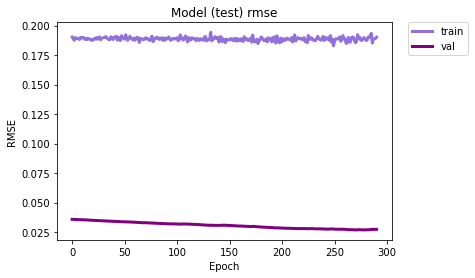

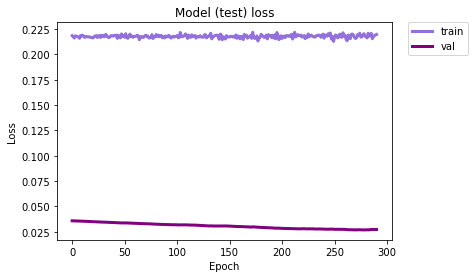

Epoch 1/300
7/7 [==============================] - 0s 61ms/step - loss: 0.1614 - mae: 0.0687 - rmse: 0.1601 - val_loss: 0.3094 - val_mae: 0.1006 - val_rmse: 0.1739
Epoch 2/300
7/7 [==============================] - 0s 56ms/step - loss: 0.1619 - mae: 0.0730 - rmse: 0.1597 - val_loss: 0.3094 - val_mae: 0.1006 - val_rmse: 0.1738
Epoch 3/300
7/7 [==============================] - 0s 61ms/step - loss: 0.1639 - mae: 0.0737 - rmse: 0.1613 - val_loss: 0.3094 - val_mae: 0.1005 - val_rmse: 0.1738
Epoch 4/300
7/7 [==============================] - 0s 59ms/step - loss: 0.1600 - mae: 0.0698 - rmse: 0.1587 - val_loss: 0.3094 - val_mae: 0.1005 - val_rmse: 0.1738
Epoch 5/300
7/7 [==============================] - 0s 68ms/step - loss: 0.1647 - mae: 0.0715 - rmse: 0.1631 - val_loss: 0.3094 - val_mae: 0.1005 - val_rmse: 0.1738
Epoch 6/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1638 - mae: 0.0715 - rmse: 0.1623 - val_loss: 0.3094 - val_mae: 0.1005 - val_rmse: 0.1738
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1622 - mae: 0.0709 - rmse: 0.1603 - val_loss: 0.3091 - val_mae: 0.0998 - val_rmse: 0.1732
Epoch 52/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1610 - mae: 0.0712 - rmse: 0.1568 - val_loss: 0.3091 - val_mae: 0.0997 - val_rmse: 0.1732
Epoch 53/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1609 - mae: 0.0695 - rmse: 0.1591 - val_loss: 0.3091 - val_mae: 0.0997 - val_rmse: 0.1732
Epoch 54/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1625 - mae: 0.0713 - rmse: 0.1599 - val_loss: 0.3091 - val_mae: 0.0997 - val_rmse: 0.1732
Epoch 55/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1614 - mae: 0.0721 - rmse: 0.1600 - val_loss: 0.3090 - val_mae: 0.0997 - val_rmse: 0.1732
Epoch 56/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1628 - mae: 0.0710 - rmse: 0.1607 - val_loss: 0.3090 - val_mae: 0.0996 - val_rmse: 0.1731
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1630 - mae: 0.0716 - rmse: 0.1616 - val_loss: 0.3088 - val_mae: 0.0989 - val_rmse: 0.1726
Epoch 102/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1622 - mae: 0.0710 - rmse: 0.1606 - val_loss: 0.3088 - val_mae: 0.0989 - val_rmse: 0.1726
Epoch 103/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1632 - mae: 0.0721 - rmse: 0.1618 - val_loss: 0.3087 - val_mae: 0.0989 - val_rmse: 0.1726
Epoch 104/300
7/7 [==============================] - 1s 81ms/step - loss: 0.1624 - mae: 0.0713 - rmse: 0.1610 - val_loss: 0.3087 - val_mae: 0.0989 - val_rmse: 0.1726
Epoch 105/300
7/7 [==============================] - 1s 81ms/step - loss: 0.1644 - mae: 0.0733 - rmse: 0.1624 - val_loss: 0.3087 - val_mae: 0.0989 - val_rmse: 0.1726
Epoch 106/300
7/7 [==============================] - 1s 77ms/step - loss: 0.1617 - mae: 0.0722 - rmse: 0.1600 - val_loss: 0.3087 - val_mae: 0.0989 - val_rmse: 0.1725
Epoc

7/7 [==============================] - 1s 93ms/step - loss: 0.1629 - mae: 0.0728 - rmse: 0.1609 - val_loss: 0.3085 - val_mae: 0.0982 - val_rmse: 0.1720
Epoch 151/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1624 - mae: 0.0729 - rmse: 0.1610 - val_loss: 0.3085 - val_mae: 0.0982 - val_rmse: 0.1720
Epoch 152/300
7/7 [==============================] - 1s 77ms/step - loss: 0.1610 - mae: 0.0713 - rmse: 0.1596 - val_loss: 0.3085 - val_mae: 0.0982 - val_rmse: 0.1720
Epoch 153/300
7/7 [==============================] - 1s 78ms/step - loss: 0.1621 - mae: 0.0713 - rmse: 0.1607 - val_loss: 0.3085 - val_mae: 0.0982 - val_rmse: 0.1720
Epoch 154/300
7/7 [==============================] - 1s 76ms/step - loss: 0.1640 - mae: 0.0736 - rmse: 0.1624 - val_loss: 0.3085 - val_mae: 0.0982 - val_rmse: 0.1720
Epoch 155/300
7/7 [==============================] - 1s 78ms/step - loss: 0.1626 - mae: 0.0721 - rmse: 0.1608 - val_loss: 0.3084 - val_mae: 0.0981 - val_rmse: 0.1720
Epoch 156/300
7/7 

7/7 [==============================] - 1s 82ms/step - loss: 0.1634 - mae: 0.0712 - rmse: 0.1617 - val_loss: 0.3082 - val_mae: 0.0976 - val_rmse: 0.1715
Epoch 200/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1618 - mae: 0.0715 - rmse: 0.1599 - val_loss: 0.3082 - val_mae: 0.0975 - val_rmse: 0.1715
Epoch 201/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1629 - mae: 0.0718 - rmse: 0.1615 - val_loss: 0.3082 - val_mae: 0.0975 - val_rmse: 0.1715
Epoch 202/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1619 - mae: 0.0704 - rmse: 0.1579 - val_loss: 0.3082 - val_mae: 0.0975 - val_rmse: 0.1715
Epoch 203/300
7/7 [==============================] - 1s 78ms/step - loss: 0.1616 - mae: 0.0719 - rmse: 0.1601 - val_loss: 0.3082 - val_mae: 0.0975 - val_rmse: 0.1715
Epoch 204/300
7/7 [==============================] - 1s 80ms/step - loss: 0.1664 - mae: 0.0739 - rmse: 0.1640 - val_loss: 0.3082 - val_mae: 0.0975 - val_rmse: 0.1715
Epoch 205/300
7/7 

7/7 [==============================] - 1s 89ms/step - loss: 0.1632 - mae: 0.0739 - rmse: 0.1609 - val_loss: 0.3079 - val_mae: 0.0968 - val_rmse: 0.1710
Epoch 249/300
7/7 [==============================] - 1s 83ms/step - loss: 0.1629 - mae: 0.0719 - rmse: 0.1613 - val_loss: 0.3079 - val_mae: 0.0968 - val_rmse: 0.1710
Epoch 250/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1625 - mae: 0.0712 - rmse: 0.1592 - val_loss: 0.3079 - val_mae: 0.0968 - val_rmse: 0.1709
Epoch 251/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1623 - mae: 0.0731 - rmse: 0.1605 - val_loss: 0.3079 - val_mae: 0.0968 - val_rmse: 0.1709
Epoch 252/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1650 - mae: 0.0730 - rmse: 0.1627 - val_loss: 0.3079 - val_mae: 0.0968 - val_rmse: 0.1709
Epoch 253/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1642 - mae: 0.0741 - rmse: 0.1622 - val_loss: 0.3079 - val_mae: 0.0968 - val_rmse: 0.1709
Epoch 254/300
7/7 

7/7 [==============================] - 1s 89ms/step - loss: 0.1621 - mae: 0.0714 - rmse: 0.1597 - val_loss: 0.3078 - val_mae: 0.0963 - val_rmse: 0.1706
Epoch 298/300
7/7 [==============================] - 1s 90ms/step - loss: 0.1630 - mae: 0.0713 - rmse: 0.1613 - val_loss: 0.3077 - val_mae: 0.0963 - val_rmse: 0.1706
Epoch 299/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1626 - mae: 0.0713 - rmse: 0.1594 - val_loss: 0.3077 - val_mae: 0.0963 - val_rmse: 0.1706
Epoch 300/300
7/7 [==============================] - 1s 90ms/step - loss: 0.1646 - mae: 0.0731 - rmse: 0.1631 - val_loss: 0.3077 - val_mae: 0.0963 - val_rmse: 0.1706
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


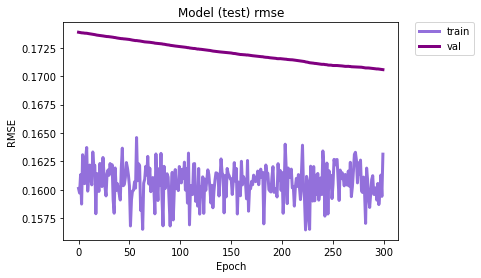

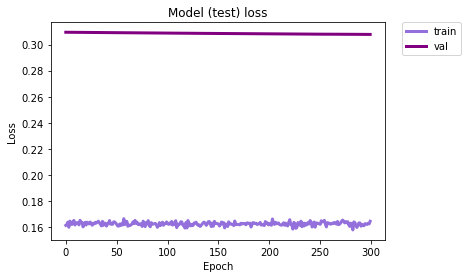

Epoch 1/300
9/9 [==============================] - 1s 97ms/step - loss: 0.1707 - mae: 0.0691 - rmse: 0.1593 - val_loss: 0.0452 - val_mae: 0.0345 - val_rmse: 0.0599
Epoch 2/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1722 - mae: 0.0701 - rmse: 0.1611 - val_loss: 0.0452 - val_mae: 0.0345 - val_rmse: 0.0599
Epoch 3/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1712 - mae: 0.0707 - rmse: 0.1599 - val_loss: 0.0452 - val_mae: 0.0345 - val_rmse: 0.0599
Epoch 4/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1705 - mae: 0.0696 - rmse: 0.1591 - val_loss: 0.0452 - val_mae: 0.0345 - val_rmse: 0.0599
Epoch 5/300
9/9 [==============================] - 1s 87ms/step - loss: 0.1717 - mae: 0.0712 - rmse: 0.1608 - val_loss: 0.0452 - val_mae: 0.0345 - val_rmse: 0.0599
Epoch 6/300
9/9 [==============================] - 1s 79ms/step - loss: 0.1688 - mae: 0.0688 - rmse: 0.1577 - val_loss: 0.0452 - val_mae: 0.0345 - val_rmse: 0.0599
Epoch 7/300
9/9 

Epoch 51/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1735 - mae: 0.0708 - rmse: 0.1622 - val_loss: 0.0451 - val_mae: 0.0343 - val_rmse: 0.0597
Epoch 52/300
9/9 [==============================] - 1s 80ms/step - loss: 0.1714 - mae: 0.0686 - rmse: 0.1599 - val_loss: 0.0451 - val_mae: 0.0343 - val_rmse: 0.0597
Epoch 53/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1718 - mae: 0.0700 - rmse: 0.1617 - val_loss: 0.0451 - val_mae: 0.0343 - val_rmse: 0.0597
Epoch 54/300
9/9 [==============================] - 1s 88ms/step - loss: 0.1707 - mae: 0.0695 - rmse: 0.1599 - val_loss: 0.0451 - val_mae: 0.0343 - val_rmse: 0.0597
Epoch 55/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1711 - mae: 0.0680 - rmse: 0.1599 - val_loss: 0.0451 - val_mae: 0.0343 - val_rmse: 0.0597
Epoch 56/300
9/9 [==============================] - 1s 95ms/step - loss: 0.1702 - mae: 0.0695 - rmse: 0.1592 - val_loss: 0.0451 - val_mae: 0.0343 - val_rmse: 0.0597
Epoch 57/3

9/9 [==============================] - 2s 174ms/step - loss: 0.1708 - mae: 0.0695 - rmse: 0.1595 - val_loss: 0.0450 - val_mae: 0.0342 - val_rmse: 0.0595
Epoch 101/300
9/9 [==============================] - 1s 129ms/step - loss: 0.1722 - mae: 0.0690 - rmse: 0.1606 - val_loss: 0.0450 - val_mae: 0.0342 - val_rmse: 0.0595
Epoch 102/300
9/9 [==============================] - 1s 123ms/step - loss: 0.1710 - mae: 0.0692 - rmse: 0.1596 - val_loss: 0.0450 - val_mae: 0.0342 - val_rmse: 0.0595
Epoch 103/300
9/9 [==============================] - 1s 132ms/step - loss: 0.1692 - mae: 0.0695 - rmse: 0.1582 - val_loss: 0.0450 - val_mae: 0.0342 - val_rmse: 0.0595
Epoch 104/300
9/9 [==============================] - 1s 89ms/step - loss: 0.1699 - mae: 0.0700 - rmse: 0.1585 - val_loss: 0.0450 - val_mae: 0.0342 - val_rmse: 0.0595
Epoch 105/300
9/9 [==============================] - 1s 95ms/step - loss: 0.1709 - mae: 0.0705 - rmse: 0.1601 - val_loss: 0.0450 - val_mae: 0.0342 - val_rmse: 0.0595
Epoch 106/300


9/9 [==============================] - 1s 88ms/step - loss: 0.1719 - mae: 0.0703 - rmse: 0.1607 - val_loss: 0.0449 - val_mae: 0.0341 - val_rmse: 0.0594
Epoch 150/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1705 - mae: 0.0695 - rmse: 0.1591 - val_loss: 0.0449 - val_mae: 0.0341 - val_rmse: 0.0594
Epoch 151/300
9/9 [==============================] - 1s 84ms/step - loss: 0.1669 - mae: 0.0675 - rmse: 0.1557 - val_loss: 0.0449 - val_mae: 0.0341 - val_rmse: 0.0594
Epoch 152/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1703 - mae: 0.0704 - rmse: 0.1590 - val_loss: 0.0449 - val_mae: 0.0341 - val_rmse: 0.0594
Epoch 153/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1699 - mae: 0.0696 - rmse: 0.1580 - val_loss: 0.0449 - val_mae: 0.0341 - val_rmse: 0.0594
Epoch 154/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1683 - mae: 0.0681 - rmse: 0.1575 - val_loss: 0.0449 - val_mae: 0.0341 - val_rmse: 0.0594
Epoch 155/300
9/9 

9/9 [==============================] - 1s 94ms/step - loss: 0.1716 - mae: 0.0718 - rmse: 0.1607 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0594
Epoch 199/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1704 - mae: 0.0722 - rmse: 0.1592 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0594
Epoch 200/300
9/9 [==============================] - 1s 91ms/step - loss: 0.1704 - mae: 0.0695 - rmse: 0.1597 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0594
Epoch 201/300
9/9 [==============================] - 1s 92ms/step - loss: 0.1653 - mae: 0.0673 - rmse: 0.1547 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0594
Epoch 202/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1717 - mae: 0.0721 - rmse: 0.1611 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0594
Epoch 203/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1709 - mae: 0.0706 - rmse: 0.1597 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0594
Epoch 204/300
9/9 

9/9 [==============================] - 1s 84ms/step - loss: 0.1692 - mae: 0.0693 - rmse: 0.1579 - val_loss: 0.0449 - val_mae: 0.0339 - val_rmse: 0.0593
Epoch 248/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1722 - mae: 0.0709 - rmse: 0.1610 - val_loss: 0.0449 - val_mae: 0.0339 - val_rmse: 0.0593
Epoch 249/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1704 - mae: 0.0700 - rmse: 0.1601 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0593
Epoch 250/300
9/9 [==============================] - 1s 90ms/step - loss: 0.1705 - mae: 0.0705 - rmse: 0.1599 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0593
Epoch 251/300
9/9 [==============================] - 1s 85ms/step - loss: 0.1702 - mae: 0.0700 - rmse: 0.1584 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0593
Epoch 252/300
9/9 [==============================] - 1s 90ms/step - loss: 0.1695 - mae: 0.0701 - rmse: 0.1584 - val_loss: 0.0449 - val_mae: 0.0340 - val_rmse: 0.0593
Epoch 253/300
9/9 

9/9 [==============================] - 1s 110ms/step - loss: 0.1717 - mae: 0.0711 - rmse: 0.1596 - val_loss: 0.0449 - val_mae: 0.0339 - val_rmse: 0.0593
Epoch 297/300
9/9 [==============================] - 1s 124ms/step - loss: 0.1736 - mae: 0.0726 - rmse: 0.1623 - val_loss: 0.0449 - val_mae: 0.0339 - val_rmse: 0.0593
Epoch 298/300
9/9 [==============================] - 1s 137ms/step - loss: 0.1711 - mae: 0.0700 - rmse: 0.1597 - val_loss: 0.0449 - val_mae: 0.0339 - val_rmse: 0.0593
Epoch 299/300
2/9 [=====>........................] - ETA: 1s - loss: 0.2704 - mae: 0.1130 - rmse: 0.2704

In [ ]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

In [ ]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [ ]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [ ]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.2',forecastSpeed[i],hour[i]
        writer.writerow(d)